# Profit Figures

This notebook generates profit-related plots for the paper.


In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path("..") / "src"))


## Parameters
Parameters match the paper; change only if exploring variants.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from metric_paper.plotting import set_plot_style
from metric_paper.roi_profit import (
    FlipProbability,
    ProfitModel,
    RoiProfitParams,
    intersection_ipv,
    profit,
)

params = RoiProfitParams(L=0.7, U=0.8, N_max=1000, V=1.0)
eta = np.linspace(0.0, 1.0, 301)
n_ratio = np.linspace(0.001, 1.0, 200)
ipv = np.linspace(0.0, 1.0, 500)

out_dir = Path("..") / "figures"
out_dir.mkdir(exist_ok=True)

set_plot_style()


In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def eta_ticks(params, include_limits=True):
    ticks = list(np.linspace(0.0, 1.0, 6))
    if include_limits:
        ticks += [params.L, params.U]
    return sorted(set(ticks))

def apply_eta_ticks(ax, params, include_limits=True):
    ticks = eta_ticks(params, include_limits)
    ax.set_xticks(ticks)
    ax.set_xticklabels([f"{t:.1f}" for t in ticks])

def apply_ratio_ticks(ax, ratios):
    ticks = np.linspace(ratios[0], ratios[-1], 6)
    ax.set_yticks(ticks)
    ax.set_yticklabels([f"{t:.2f}" for t in ticks])

def dual_heatmap(eta_vals, n_vals, z, title, path, params):
    fig, (ax_main, ax_zoom) = plt.subplots(
        1, 2, figsize=(11, 5), gridspec_kw={"width_ratios": [3.2, 1.2]}
    )
    im_main = ax_main.imshow(
        z, origin="lower", extent=[eta_vals[0], eta_vals[-1], n_vals[0], n_vals[-1]],
        aspect="auto", cmap="magma",
    )
    ax_main.set_title(title)
    ax_main.set_xlabel(r"$\eta$")
    ax_main.set_ylabel(r"$N_\mathrm{ratio}$")
    ax_main.axvline(params.L, linestyle="--", linewidth=1)
    ax_main.axvline(params.U, linestyle="--", linewidth=1)
    apply_eta_ticks(ax_main, params, include_limits=True)
    apply_ratio_ticks(ax_main, n_vals)
    divider_main = make_axes_locatable(ax_main)
    cax_main = divider_main.append_axes("right", size="3%", pad=0.05)
    cbar_main = fig.colorbar(im_main, cax=cax_main)
    cbar_main.set_label("profit")
    mask = (eta_vals >= params.L) & (eta_vals <= params.U)
    eta_zoom = eta_vals[mask]
    z_zoom = z[:, mask]
    im_zoom = ax_zoom.imshow(
        z_zoom, origin="lower",
        extent=[eta_zoom[0], eta_zoom[-1], n_vals[0], n_vals[-1]],
        aspect="auto", cmap="viridis",
    )
    ax_zoom.set_xlabel(r"$\eta$")
    ax_zoom.set_yticks([])
    ax_zoom.set_xlim(params.L, params.U)
    ax_zoom.set_xticks([params.L, params.U])
    ax_zoom.set_xticklabels([f"{params.L:.1f}", f"{params.U:.1f}"])
    divider_zoom = make_axes_locatable(ax_zoom)
    cax_zoom = divider_zoom.append_axes("right", size="5%", pad=0.08)
    cbar_zoom = fig.colorbar(im_zoom, cax=cax_zoom)
    cbar_zoom.set_label("profit (zoom)")
    fig.tight_layout()
    fig.savefig(path)
    plt.show()


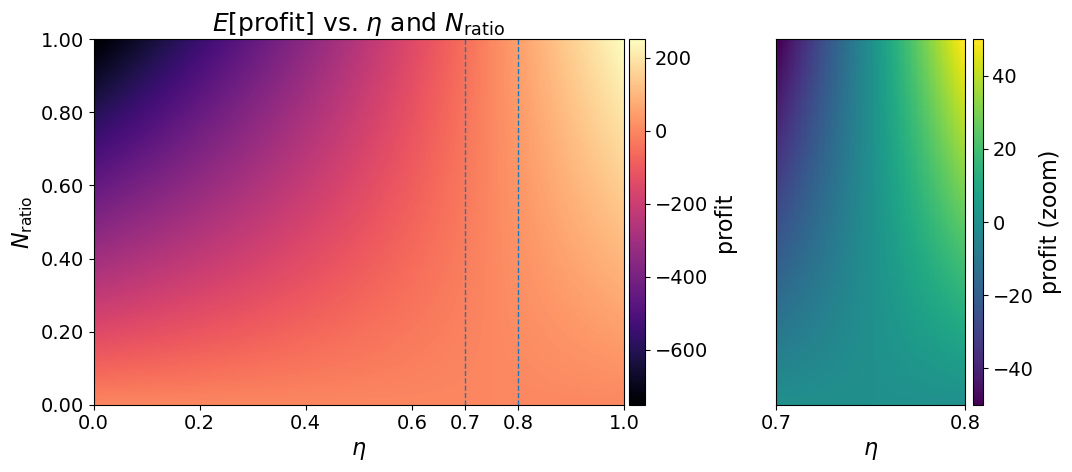

In [4]:
eta_grid, n_grid = np.meshgrid(eta, n_ratio)
n_i = n_grid * params.N_max
e_profit = n_i * params.V * (eta_grid - params.mean())

dual_heatmap(
    eta, n_ratio, e_profit,
    r"$E[\mathrm{profit}]$ vs. $\eta$ and $N_\mathrm{ratio}$",
    out_dir / "fig8_profit_expected_heatmap.svg",
    params,
)

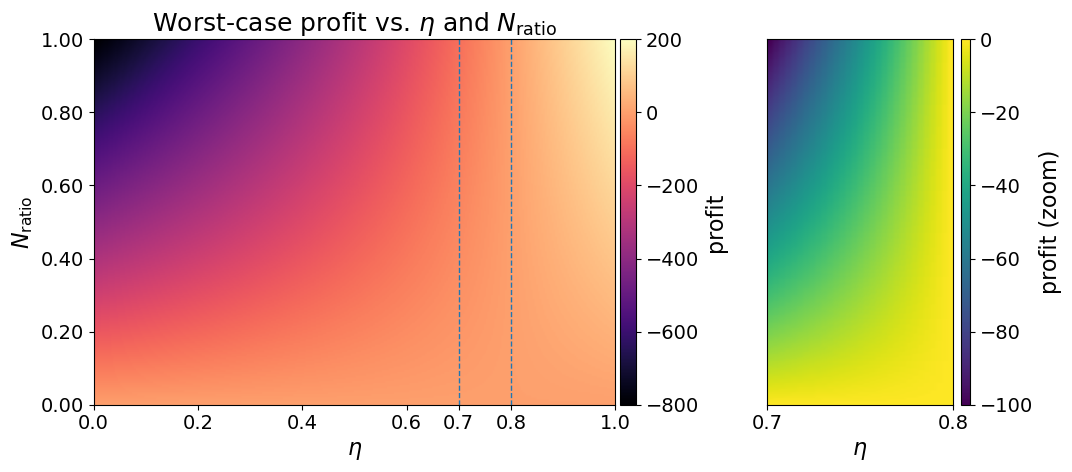

In [5]:
worst = n_i * params.V * (eta_grid - params.U)

dual_heatmap(
    eta, n_ratio, worst,
    r"Worst-case profit vs. $\eta$ and $N_\mathrm{ratio}$",
    out_dir / "fig8_profit_worst_heatmap.svg",
    params,
)

In [6]:
def find_models(params, trials=3000, seed=0):
    rng = np.random.default_rng(seed)
    eta_vals = np.linspace(0.1, 0.95, 18)
    n_vals = np.arange(50, 1000)
    for _ in range(trials):
        eta_a, eta_b, eta_c = rng.choice(eta_vals, 3, replace=True)
        n_a, n_b, n_c = rng.choice(n_vals, 3, replace=True)
        a = ProfitModel(eta=eta_a, N=n_a)
        b = ProfitModel(eta=eta_b, N=n_b)
        c = ProfitModel(eta=eta_c, N=n_c)
        x_ab = intersection_ipv(a, b)
        x_ac = intersection_ipv(a, c)
        x_bc = intersection_ipv(b, c)
        if np.isnan(x_ab) or np.isnan(x_ac) or np.isnan(x_bc):
            continue
        if params.L < x_ab < params.U and 0 < x_ac < params.L and 1 > x_bc > params.U:
            return a, b, c, (x_ab, x_ac, x_bc)
    return None


A ProfitModel(eta=np.float64(0.7), N=np.int64(675))
B ProfitModel(eta=np.float64(0.1), N=np.int64(82))
C ProfitModel(eta=np.float64(0.7499999999999999), N=np.int64(440))
x_ab, x_ac, x_bc (np.float64(0.7829679595278245), np.float64(0.6063829787234043), np.float64(0.8988826815642457))


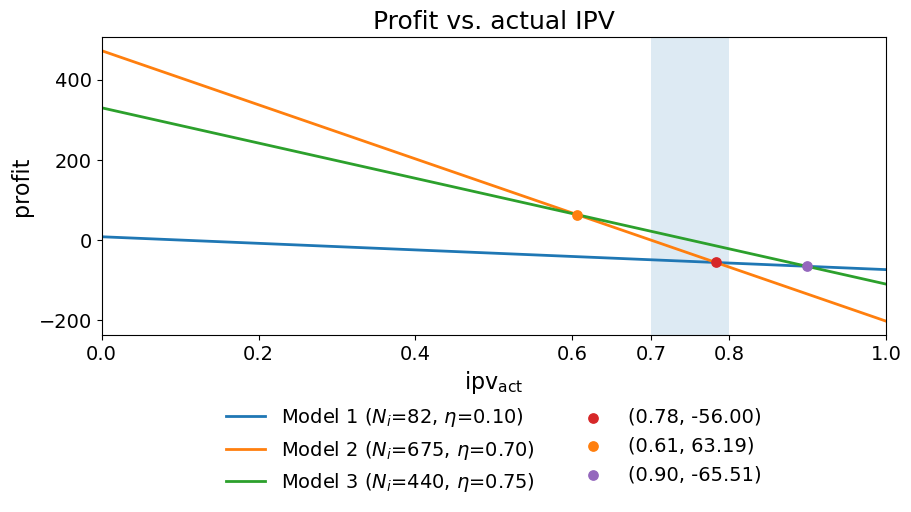

In [7]:
result = find_models(params)
if result is None:
    raise RuntimeError("No valid model triple found.")

a, b, c, (x_ab, x_ac, x_bc) = result
print("A", a)
print("B", b)
print("C", c)
print("x_ab, x_ac, x_bc", (x_ab, x_ac, x_bc))

fig, ax = plt.subplots(figsize=(9, 5), constrained_layout=True)

models_sorted = sorted([a, b, c], key=lambda m: m.eta)
for i, m in enumerate(models_sorted, start=1):
    ax.plot(ipv, profit(m, ipv, params), linewidth=2.0, label=rf"Model {i} ($N_i$={int(m.N)}, $\eta$={m.eta:.2f})")

ax.axvspan(params.L, params.U, alpha=0.15)

y_ab = profit(a, x_ab, params)
y_ac = profit(a, x_ac, params)
y_bc = profit(b, x_bc, params)

colors = ["tab:red", "tab:orange", "tab:purple"]
xs = [x_ab, x_ac, x_bc]
ys = [y_ab, y_ac, y_bc]
labels = [
    rf"({x_ab:.2f}, {y_ab:.2f})",
    rf"({x_ac:.2f}, {y_ac:.2f})",
    rf"({x_bc:.2f}, {y_bc:.2f})",
]

for x, y, ccol, lab in zip(xs, ys, colors, labels):
    ax.scatter([x], [y], s=45, color=ccol, zorder=5, label=lab)

ax.set_xlabel(r"$\mathrm{ipv}_{\mathrm{act}}$")
ax.set_ylabel("profit")
ax.set_title("Profit vs. actual IPV")
ax.set_xlim(0.0, 1.0)

ticks = eta_ticks(params, include_limits=True)
ax.set_xticks(ticks)
ax.set_xticklabels([f"{t:.1f}" for t in ticks])

ax.legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.18), ncol=2)
fig.savefig(out_dir / "fig8_profit_models_abc.svg")
plt.show()


In [8]:
def flip_grid(params, r_n, eta_vals):
    n_b = params.N_max
    n_a = int(round(r_n * n_b))
    flip = FlipProbability(params, tie_value=0.0)
    grid = np.zeros((len(eta_vals), len(eta_vals)))
    for i, eta_a in enumerate(eta_vals):
        for j, eta_b in enumerate(eta_vals):
            a = ProfitModel(eta=eta_a, N=n_a)
            b = ProfitModel(eta=eta_b, N=n_b)
            grid[j, i] = flip.p_flip(a, b)
    return grid, n_a, n_b


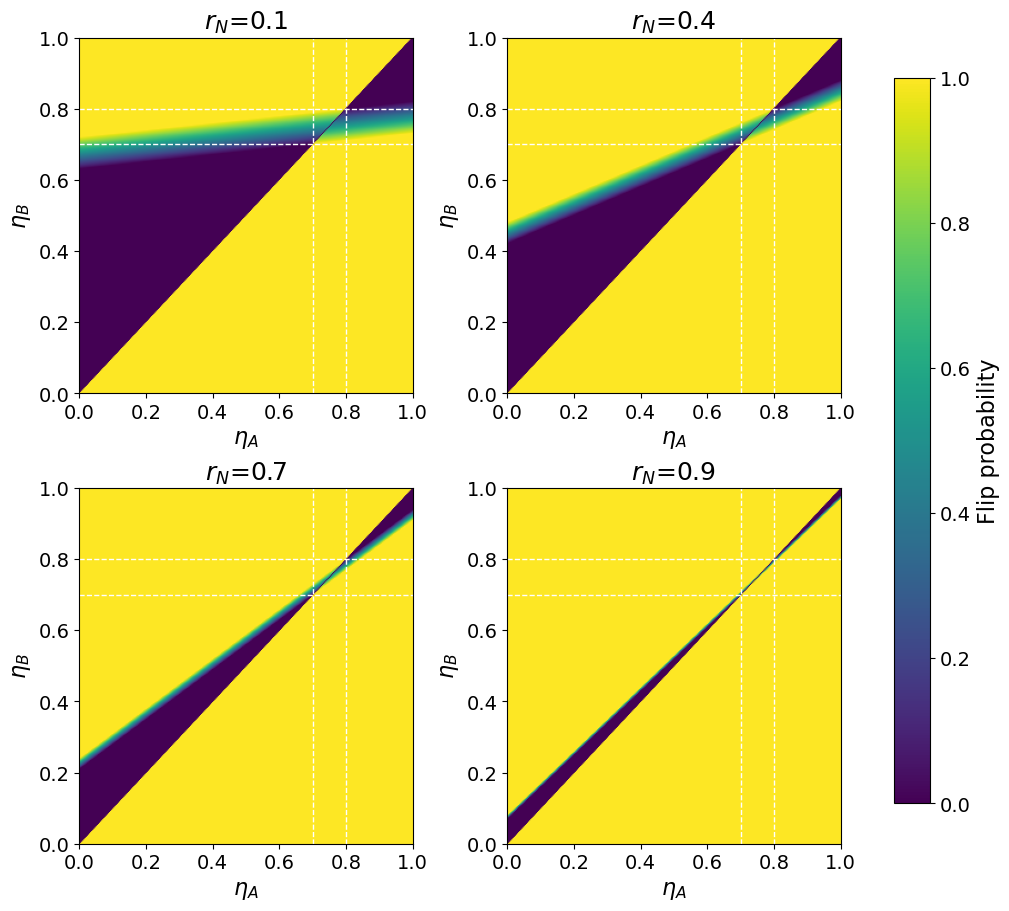

In [9]:
r_values = [0.1, 0.4, 0.7, 0.9]
eta_grid = np.linspace(0.0, 1.0, 301)

fig, axes = plt.subplots(2, 2, figsize=(10, 9), constrained_layout=True)
for ax, r_n in zip(axes.flat, r_values):
    grid, n_a, n_b = flip_grid(params, r_n, eta_grid)
    im = ax.imshow(
        grid, origin="lower", extent=[0, 1, 0, 1],
        cmap="viridis", vmin=0, vmax=1, aspect="auto",
    )
    ax.set_title(f"$r_N$={r_n:.1f}")
    ax.set_xlabel(r"$\eta_A$")
    ax.set_ylabel(r"$\eta_B$")
    ax.axvline(params.L, color="white", linestyle="--", linewidth=1)
    ax.axvline(params.U, color="white", linestyle="--", linewidth=1)
    ax.axhline(params.L, color="white", linestyle="--", linewidth=1)
    ax.axhline(params.U, color="white", linestyle="--", linewidth=1)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9)
cbar.set_label("Flip probability")
fig.savefig(out_dir / "fig8_profit_flip_probability.svg")
plt.show()
